#### Advanced Statistics for Data Science (Spring 2022)
# Home Assignment 3
#### Topics:
- Statistical Estimation
- Hypothesis Testing in one and two samples

#### Due: 25/04/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: Tzach Larboni

**Student ID**: 302673355

**Date**: 24.04.2022

$
\newcommand{\Id}{{\mathbf{I}}}  
\newcommand{\SSE}{\mathsf{SSE}}
\newcommand{\SSR}{\mathsf{SSR}}
\newcommand{\MSE}{\mathsf{MSE}}
\newcommand{\simiid}{\overset{iid}{\sim}}
\newcommand{\ex}{\mathbb E}
\newcommand{\var}{\mathrm{Var}}
\newcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\newcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\newcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\newcommand{\reals}{\mathbb R}
\newcommand{\Ncal}{\mathcal N}
\newcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\tr}{\operatorname{Tr}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\sign}{\operatorname{sign}}
$


<hr>
<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.linalg
import math
import statsmodels.formula.api as smf


## Problem 1 (Variance Estimation)

Consider the variance estimate
$$
s^2 = \frac{1}{n-1} \sum_{i=1}^n(y_i - \bar{y})^2. 
$$
If $Y_i \simiid \Ncal(\mu,\sigma^2)$, then 
$$
\frac{n-1}{\sigma^2}s^2 \sim \chi^2_{n-1}.
$$
1. Use this information to derive a $1-\alpha$ coinfidence interval for $\sigma^2$ (express $L$ and $U$ in terms of $s^2$, $n$, and the relevant quantiles of the $\chi^2$ distribution). 
2. For $n = 2,\ldots,10$ and $\alpha=0.05$, report on the lower ($L$) and upper ($U$) values of the coinfidence interval in terms of $s^2$. 
3. How large $n$ must be to obtain a $0.95$ coinfidence interval of size $0.1s^2$? 

The point: the number of degrees of freedom needed for a reasonable ($10\%$ range) estimate of the variance can be very large. Sometimes, much larger than our data permit.




### Answer
##### Part 1

We know that $$\frac{n-1}{\sigma^2}s^2 \sim \chi^2_{n-1} $$
Hence $$ \chi^2_{1-\frac{\alpha}{2}} < \frac{n-1}{\sigma^2}s^2 < \chi^2_\frac{\alpha}{2}$$
If we clear the fractions we'll get $$\frac{n-1}{\chi^2_{1-\frac{\alpha}{2}}} s^2 < \sigma^2 < \frac{n-1}{\chi^2_\frac{\alpha}{2}} s^2$$

Meaning, $$L =  \frac{n-1}{\chi^2_{1-\frac{\alpha}{2}}} s^2 $$
$$U = \frac{n-1}{\chi^2_\frac{\alpha}{2}} s^2 $$

#### Part 2

In [2]:
ns = np.linspace(2, 10, num=9)
alpha = 0.05

def get_c_i(n, alpha, should_print=False):
    num = dof = n - 1
    u_den = st.chi2.ppf(alpha/2, dof)
    l_den = st.chi2.ppf(1 - alpha/2, dof)
    if should_print:
        print(f"For n = {n}:\n   L = {num/l_den:.3f} * s^2 \n   U = {num/u_den:.3f} * s^2")
    return (num/l_den, num/u_den)

In [3]:
for n in ns:
    get_c_i(n, alpha, should_print=True)

For n = 2.0:
   L = 0.199 * s^2 
   U = 1018.258 * s^2
For n = 3.0:
   L = 0.271 * s^2 
   U = 39.498 * s^2
For n = 4.0:
   L = 0.321 * s^2 
   U = 13.902 * s^2
For n = 5.0:
   L = 0.359 * s^2 
   U = 8.257 * s^2
For n = 6.0:
   L = 0.390 * s^2 
   U = 6.015 * s^2
For n = 7.0:
   L = 0.415 * s^2 
   U = 4.849 * s^2
For n = 8.0:
   L = 0.437 * s^2 
   U = 4.142 * s^2
For n = 9.0:
   L = 0.456 * s^2 
   U = 3.670 * s^2
For n = 10.0:
   L = 0.473 * s^2 
   U = 3.333 * s^2


#### Part 3

In [4]:
ns = np.array(range(2,1_000_000))
for n in ns:
    l,u = get_c_i(n, alpha)
    if u-l <= 0.1:
        print(f"To obstain a cofidence interval in the size of 0.1*s^2, we need to have at least {n} samples")
        break

To obstain a cofidence interval in the size of 0.1*s^2, we need to have at least 3082 samples


## Problem 2 (Correlated Data)

Suppose that $Y_1,\ldots,Y_n$ has each mean $\mu$ and variance $\sigma^2$, but 
$$
\rho_{ij} := \mathrm{Corr}(Y_i,Y_j) = \begin{cases}
1 & i=j \\
\rho & |i-j| = 1 \\
0 & |i-j| > 1
\end{cases}.
$$
This situation arise when an observation $i$ may depend to some extent on only the previous observation’s white noise: an one-lag "holdeover effect". This is also known as the "lag-1 moving average" model (MA(1)). 

1. Show that:
  - $$\mathrm{Var}(\bar{Y}) = \frac{\sigma^2}{n}(1+ 2\rho \frac{n-1}{n})$$
Namely, positive correlation increases varaince. Hint: use that $\mathrm{Var}(U+V) = \mathrm{Var}(U) + \mathrm{Var}(V) + 2 \mathrm{Cov}(U,V)$ and induction or recursive computation over $n$. Another option is to write $Y = \Sigma^{1/2}Z$ where $Z\sim \Ncal(0,I)$ and $\Sigma^{1/2}$ is symmetric with  $\Sigma^{1/2}\Sigma^{1/2} = \Sigma$ has the desired covariance stracture.  

  - $$\qquad \ex[{s^2}] = \sigma^2(1 - 2\rho/n)$$
  where $s^2$ is the standard varince estiamte. 
Namely, with positive correlation the "variety" in the data is smaller. 

  - **(Bonus)** The t-statistic statisfies
$$
t = \sqrt{n} \frac{\bar{Y}-\mu}{s} \to \Ncal(0,1 + 2 \rho),\quad n \to \infty
$$
Hint: you may use the following version of Slutsky's Theorem: for two sequences of RV U_n and V_n, if $U_n \overset{D}{\to} U$ and $V_n \overset{p}{\to} c$ (constant), then $ V_n U_n \overset{D}{\to} cU$
2. Verify your answer to the first two items in 1 using simulations. Use `nMonte = 10000` problem instances. In each instance, use a sample size of `n = 10` with $\sigma=1$ and $\rho \in \{\pm 0.1, \pm 0.3, \pm0.5\}$. The function `genrate_correlated_data` below generates noramlly distributed data satisfying the correlation model above. 

3. Suppose $\rho>0$
 - Derive a $1-\alpha$ confidence interval based on $s$ and the $t$-distribution with $n-1$ DoF. Does your interval 
 contains the value of $\mu$ more or less often than $1-\alpha$? Verify using a simulation with `nMonte = 10000` problem instances of sampes size `n=100`. Also use $\alpha=0.05$, $\rho=.25$, $\sigma =1$, and $\mu_0=2$. 
 
 - Suppose that we reject $H_0\,:\,\mu = \mu_0$ whenever $t$ exceeds the critical value $t_{n-1}^{1-\alpha/2}$. Would our P-value be too small or too large? Would we reject more or less often then $\alpha$ if the null $\mu = \mu_0$ is true? Verify using a simulation with `nMonte = 10000` problem instances of sampes size `n=100`. Also use $\alpha=0.05$, $\rho=.25$, $\sigma =1$, and $\mu_0=2$. 
 
 - Would your answer to the preivous two items change if $\rho < 0$? how?

The point: correlation in our data is bad because it makes us make wrong descisions. The effect of correlation is much worst than non-nomrality since the latter diminishes with $n$ due to the CLT. 


### Answer
##### Part 1.1

We'll prove by induction:

1. Base case  
If $n=2$, then $$Var(\bar{Y}) = Var(\frac{Y_1+Y_2}{2}) = Var(\frac{Y_1}{2}) + Var(\frac{Y_2}{2}) + 2Cov(\frac{Y_1}{2}, \frac{Y_2}{2})$$ 
Since $Cov(X,Y) = \rho \sigma_X \sigma_Y $, we'll plug in:
$$ =\frac{1}{4}[Var(Y_1) + Var(Y_2) + 2\rho Std(\frac{Y_1}{2})Std(\frac{Y_2}{2}) $$
$$ =\frac{\sigma^2}{2} + 2\rho \frac{\sigma^2}{4}$$
$$ =\frac{\sigma^2}{2}(1 + 2\rho \frac{1}{2})$$
$$ =\frac{\sigma^2}{n}( 1 + {2\rho} \frac{n-1}{n})$$

2. Induction hypothesis:
$$Var(\bar{Y_n}) = \frac{\sigma^2}{n}(1+ 2\rho \frac{n-1}{n})$$

3. Induction step:
$$ Var(\bar(Y_{n+1} = Var(\frac{1}{n+1}\Sigma_{i=1}^{n+1}Y_i)$$
We'll multiply and divide by $n$
$$ = Var(\frac{n}{n+1} * \frac{1}{n} \Sigma_{i=1}^{n+1}Y_i)$$
$$ = (\frac{n}{n+1})^2 Var(\frac{1}{n} \Sigma_{i=1}^{n+1}Y_i)$$
$$ = (\frac{n}{n+1})^2 Var(\frac{1}{n} \Sigma_{i=1}^{n}Y_i + \frac{1}{n}Y_{n+1}) $$
$$ = (\frac{n}{n+1})^2 [Var(\bar{Y_n}) + Var(\frac{1}{n} Y_{n+1}) + 2Cov(\bar{Y_n},\frac{1}{n} Y_{n+1})] $$
$$ = (\frac{n}{n+1})^2 [\frac{\sigma^2}{n}(1+ 2\rho \frac{n-1}{n}) + \frac{1}{n^2} \sigma^2 + 2Cov(\bar{Y_n},\frac{1}{n} Y_{n+1})] $$

Let's examine $Cov(\bar{Y_n},\frac{1}{n} Y_{n+1})$. Since $\bar{Y_n} = \frac{Y_1 + Y+2 + ... + Y_n}{n}$ we can deduce
$$ Cov(\bar{Y_n},\frac{1}{n} Y_{n+1}) = \frac{1}{n^2}[Cov(Y_1,Y_{n+1}) + Cov(Y_2,Y_{n+1}) + ... + Cov(Y_n,Y_{n+1}) $$
$$ = \frac{1}{n^2} (0 + 0 + ... \rho \sigma^2)$$
$$ = \frac{\rho \sigma^2}{n^2} $$

Plug it back in:
$$ = (\frac{n}{n+1})^2 [\frac{\sigma^2}{n}(1+ 2\rho \frac{n-1}{n}) + \frac{1}{n^2} \sigma^2 +2\frac{\rho \sigma^2}{n^2}] $$
$$ = (\frac{n}{n+1})^2 * \frac{\sigma^2}{n}[1 + 2\rho \frac{n-1}{n} + \frac{1}{n} + 2\frac{\rho}{n}]$$
$$ = (\frac{n\sigma^2}{(n+1)^2}) (\frac{n + 2n\rho - 2\rho + 1 +2\rho}{n}) $$
$$ = (\frac{\sigma^2}{(n+1)^2}) (n + 2n\rho + 1) $$
$$ = (\frac{\sigma^2}{n+1}) (\frac{n + 1 + 2n\rho}{n + 1})$$
$$ = (\frac{\sigma^2}{n+1}) (1 + \frac{2n\rho}{n + 1})$$
$$Q.E.D$$

##### Part 1.2
We know that by definition:
$$\ex[{s^2}] = \ex[\frac{\Sigma_{i=1}^{n}(Y_i-\bar{Y})^2}{n-1}] $$
$$ = \frac{1}{n-1} \ex[\Sigma_{i=1}^{n}[(Y_i-\mu)- (\bar{Y}-\mu)] ^2 ]$$
$$ = \frac{1}{n-1}[(\Sigma_{i=1}^{n}Var(Y_i)) - nVar(\bar{Y})] $$
We'll plug in the answer from the previous part:
$$ \ex[{s^2}] = \frac{1}{n-1}[n\sigma^2 - n \frac{\sigma^2}{n}(1+\frac{2\rho(n-1)}{n})] $$
$$ = \sigma^2 \frac{1}{n-1} (n - 1 - \frac{2\rho(n-1)}{n}$$
$$ = \sigma^2 (\frac{n-1-2\rho(n-1)}{(n-1)n} $$
$$ = \frac{\sigma^2(n-1)(1-2\rho}{n(n-1)}$$
$$ = \sigma^2 \frac{1-2\rho}{n}$$
$$ Q.E.D$$

#### Part 2

In [5]:
def genrate_correlated_data(n: int, rho: float, mu: float, sigma: float) -> np.ndarray:
    """
    Generate samples from the model:
    Yi ~ N(mu, sigma^2) and Corr(Yi,Yj) = ( i == j ) + rho * ( abs( i - j ) == 1 )
    
    Args:
    -----
    :n:     sample size
    :rho:   desired one lag correlation between samples
    :mu:    mean
    :sigma: standard deviation
    
    """
    assert sigma > 0
    
    # build desired covariance matrix
    Sig = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i==j : 
                Sig[i,j] = 1
            if np.abs(i-j) == 1:
                Sig[i,j] = rho
                Sig[j,i] = rho
                
    # get matrix square root of covariance matrix:
    Sig_sqrt = np.linalg.cholesky(sigma**2 * Sig)
    
    # sample from the standard normal dist. and transform 
    # so that the result is a normal vector with the desired 
    # covaraince structure
    return mu + Sig_sqrt @ np.random.randn(n)


  - $$\mathrm{Var}(\bar{Y}) = \frac{\sigma^2}{n}(1+ 2\rho \frac{n-1}{n})$$

  - $$\qquad \ex[{s^2}] = \sigma^2(1 - 2\rho/n)$$


In [6]:
nMonte = 10000
n = 10
sigma = 1
mu = 0
rhos = [0.1, -0.1, 0.3, -0.3, 0.5, -0.5]

def calc_theoretic_y_bar_variance(sigma, n, rho):
    return (sigma ** 2 / n) * (1 + 2 * rho * (n - 1)/n)
    
def calc_theoretic_mean_sample_var(sigma, rho, n):
    return sigma **2 * (1 - 2 * rho / n)

In [7]:
for rho in rhos:    
    data = [genrate_correlated_data(n=n, rho=rho, mu=mu, sigma=sigma) for _ in range(nMonte)]
    data = np.asarray(data)
    
    y_bars = np.mean(data, axis=1).reshape(-1,1)
    sigma_squared = (1 / (n - 1)) * np.sum((data - y_bars) ** 2, axis=1)
    
    empirical_y_bars_var = np.var(y_bars)
    empirical_sigma_squared_mean = np.mean(sigma_squared) 

    theoretical_y_bar_var = calc_theoretic_y_bar_variance(sigma, n, rho)
    theoretical_sigma_squared_mean = calc_theoretic_mean_sample_var(sigma=sigma, rho=rho, n=n)

    print(f"For rho {rho}:\n   The theoretical y bar variance is {theoretical_y_bar_var:.3f}, while the emprical is {empirical_y_bars_var:.3f}.\n   The theoretical sigma squared mean is {theoretical_sigma_squared_mean:.3f}, while the emprical is {empirical_sigma_squared_mean:.3f}")
    

For rho 0.1:
   The theoretical y bar variance is 0.118, while the emprical is 0.122.
   The theoretical sigma squared mean is 0.980, while the emprical is 0.973
For rho -0.1:
   The theoretical y bar variance is 0.082, while the emprical is 0.081.
   The theoretical sigma squared mean is 1.020, while the emprical is 1.019
For rho 0.3:
   The theoretical y bar variance is 0.154, while the emprical is 0.153.
   The theoretical sigma squared mean is 0.940, while the emprical is 0.942
For rho -0.3:
   The theoretical y bar variance is 0.046, while the emprical is 0.047.
   The theoretical sigma squared mean is 1.060, while the emprical is 1.071
For rho 0.5:
   The theoretical y bar variance is 0.190, while the emprical is 0.188.
   The theoretical sigma squared mean is 0.900, while the emprical is 0.901
For rho -0.5:
   The theoretical y bar variance is 0.010, while the emprical is 0.010.
   The theoretical sigma squared mean is 1.100, while the emprical is 1.102


#### Part 3

3. Suppose $\rho>0$
 - Derive a $1-\alpha$ confidence interval based on $s$ and the $t$-distribution with $n-1$ DoF. Does your interval 
 contains the value of $\mu$ more or less often than $1-\alpha$? Verify using a simulation with `nMonte = 10000` problem instances of sampes size `n=100`. Also use $\alpha=0.05$, $\rho=.25$, $\sigma =1$, and $\mu_0=2$. 
 
 - Suppose that we reject $H_0\,:\,\mu = \mu_0$ whenever $t$ exceeds the critical value $t_{n-1}^{1-\alpha/2}$. Would our P-value be too small or too large? Would we reject more or less often then $\alpha$ if the null $\mu = \mu_0$ is true? Verify using a simulation with `nMonte = 10000` problem instances of sampes size `n=100`. Also use $\alpha=0.05$, $\rho=.25$, $\sigma =1$, and $\mu_0=2$. 
 
 - Would your answer to the preivous two items change if $\rho < 0$? how?

The point: correlation in our data is bad because it makes us make wrong descisions. The effect of correlation is much worst than non-nomrality since the latter diminishes with $n$ due to the CLT. 


In [8]:
n = 100
alpha = 0.05
rho_positive = 0.25
rho_negative = -1 * rho_positive
sigma = 1
mu_0 = 2
nMonte = 100_0

def calc_hyptohesis(n, alpha, rho, sigma, mu, mu_0, nMonte):
    df = pd.DataFrame()

    for _ in range(nMonte):
        data = genrate_correlated_data(n=n, rho=rho, mu=mu_0, sigma=sigma)
        y_bar_i = np.mean(data)
        s = np.sqrt((1 / (n - 1)) * np.sum((data - y_bar_i) ** 2))
        t_alpha_bar = st.t.ppf(1 - alpha / 2, df=n-1)

        l = mu_0 - (s / np.sqrt(n)) * t_alpha_bar
        u = mu_0 + (s / np.sqrt(n)) * t_alpha_bar
        t_stat = (y_bar_i - mu_0) / (s/ np.sqrt(n))
        df = df.append(dict(
            true_mu = mu,
            alpha = alpha,
            t_stat = t_stat,
            n = n,
            s = s,
            l = l,
            u = u,
            reject_h_0 = t_stat > st.t.ppf(1 - alpha / 2, df= n - 1),
            mu_in_ci = l <= y_bar_i <= u
            ), ignore_index=True)
    
    print(f"For rho = {rho}, Mu appears in the CI in {df['mu_in_ci'].value_counts()[1.0]/len(df):.2f}% of the times, while we expected {1-alpha}% of the times.")
    print(f"If we were to reject H0 if t exceeded the critical value mentioned, we would reject H0 {df['reject_h_0'].value_counts()[1.0]/len(df):.2f}% of the time. The difference is {df['reject_h_0'].value_counts()[1.0]/len(df) - alpha:.2f}.")
    
    return None
                    
                    

In [9]:
calc_hyptohesis(n=n, alpha=alpha, rho=rho_positive, sigma=sigma, mu=0, mu_0=2, nMonte=nMonte)

For rho = 0.25, Mu appears in the CI in 0.90% of the times, while we expected 0.95% of the times.
If we were to reject H0 if t exceeded the critical value mentioned, we would reject H0 0.05% of the time. The difference is -0.00.


In [10]:
calc_hyptohesis(n=n, alpha=alpha, rho=rho_negative, sigma=sigma, mu=0, mu_0=2, nMonte=nMonte)

For rho = -0.25, Mu appears in the CI in 0.99% of the times, while we expected 0.95% of the times.
If we were to reject H0 if t exceeded the critical value mentioned, we would reject H0 0.00% of the time. The difference is -0.05.


It seems like when $\rho > 0$ we are rejecting more than $\alpha$ by a little bit, and if $\rho < 0$ we are rejecting more than $\alpha$ by quite a lot.

## Problem 3 (Regression and Hypothesis Testing)

The dataset for this problem is available in the file temp_TLV_beach.csv, which was taken directly from the meterological service website (https://ims.data.gov.il/ims/1). 

We consider monitoring changes in rainfall/precipitation over the years at Station 136320 located at Tel-Aviv beach area. 
To do so, we will set up a standard linear model with $p = 3$ features, where for dates (times) $t \in \{0,1,\ldots,366\}$ (we have 366 for leap years) we set
$$
y_t = \beta_0 + \beta_1 \cos( 2\pi(t/365)) + \beta_2 \sin( 2\pi(t/365)) + \epsilon_t,\qquad t=1,\ldots,n. 
\label{eq:model} \tag{2}
$$
(note that the dataset does not contain measurments from all days in the range)

1) Set $y_t = \texttt{Rainfall}$. 
 - Plot $y_t$ versus $t=$`Date` and identify winter times.

- Find the LS regression coefficients $\beta$; plot the fitted response $\hat{y}_t$ over time along with the original response $y_t$. 

 - Test whether the fitted model significantly improves on the trival model $y_t = \beta'_0 + \epsilon_t$.
 
 - For each parameter $p$, report the P-value for testing $H_0\,:\,\hat{\beta}_p = 0$ and indicate whether this parameter is 
significantly different than $0$ at level $\alpha = 0.01$. 
(for this item, you can either evaluate everything from the formulas provded in class or use a statistical package like `statsmodels`)

You may use the code below to format the `Date` column correctly and extract other relevant information from it. 

### Answer
#### Part 1

In [11]:
data = pd.read_csv('rainfall_TLV_beach.csv')

data['Date'] = pd.to_datetime(data.Date, format="%d-%m-%Y")
data['DayOfYear'] = data.Date.dt.day_of_year
data['Month'] = data.Date.dt.month
data['Year'] = data.Date.dt.year

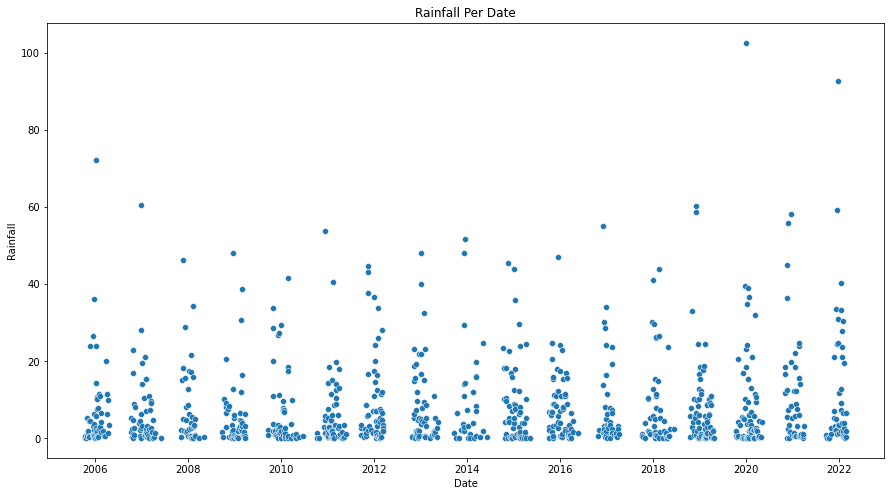

In [12]:
plt.rcParams['figure.figsize'] = [15, 8]
y_t = data['Rainfall']
sns.scatterplot(y=y_t, x=data['Date'])
plt.title('Rainfall per date'.title())
plt.show()

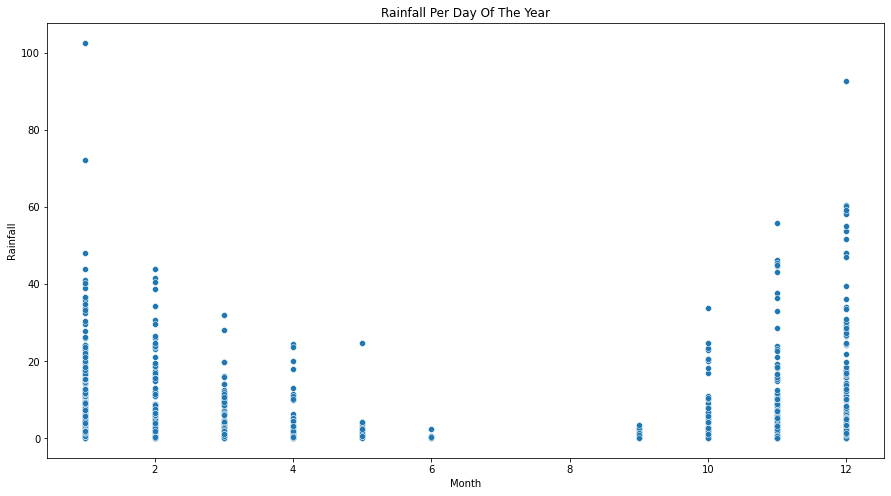

In [13]:
sns.scatterplot(y=y_t, x=data['Month'])
plt.title('Rainfall per day of the year'.title())
plt.show()

In [14]:
print(f"It looks like the months {sorted(data['Month'][data['Rainfall'] > 30].value_counts().keys())} are the winter months, as they contain the rainest days")

It looks like the months [1, 2, 3, 10, 11, 12] are the winter months, as they contain the rainest days


In [15]:
data['X_1'] = np.cos(2* np.pi * data['DayOfYear']/365)
data['X_2'] = np.sin(2* np.pi * data['DayOfYear']/365)    


X = data[['X_1', 'X_2']]
Z = np.c_[np.ones_like(y_t), X]

beta_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ y_t

print(f"The LS estimator Beta hat is the vector {[round(b,2) for b in list(beta_hat)]}^T")

The LS estimator Beta hat is the vector [4.55, 5.87, -0.91]^T


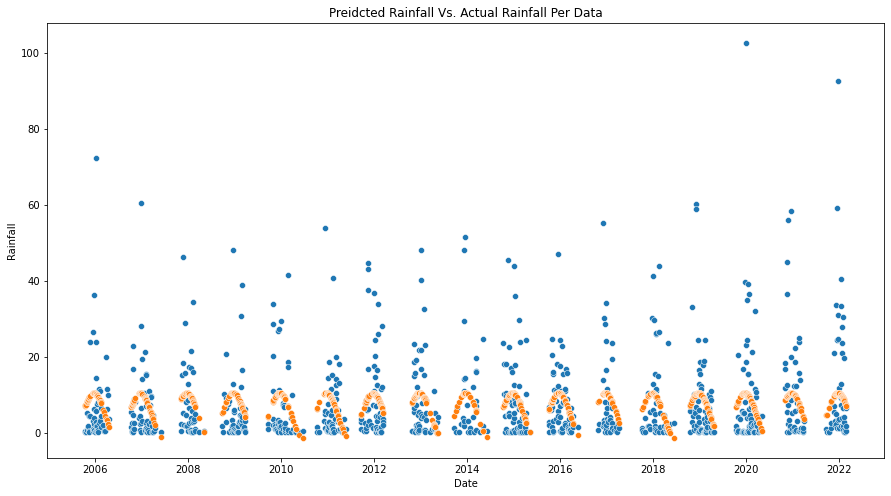

In [16]:
y_hat = Z @ beta_hat 
sns.scatterplot(y=y_t, x=data['Date'], palette='blue')
sns.scatterplot(y=y_hat, x=data['Date'], palette='red')
plt.title('preidcted rainfall vs. actual rainfall per data'.title())
plt.show()

In [17]:
data['trivial'] = np.ones_like(len(data))
X_trivial = data['trivial']
Z_trivial = np.c_[np.ones_like(y_t)]

beta_hat_trivial = np.linalg.inv(Z_trivial.T @ Z_trivial) @ Z_trivial.T @ y_t
y_hat_trivial = Z_trivial @ beta_hat_trivial

print(f"The LS estimator Beta hat is the vector {[round(b,2) for b in list(beta_hat_trivial)]}^T")

The LS estimator Beta hat is the vector [8.14]^T


In [18]:
def calc_sss(y_hat, y, r_squared_mode=False):
    y_bar = np.mean(y)
    ss_fit = np.sum((y_hat - y_bar)**2)
    ss_tot = np.sum((y - y_bar)**2)
    if r_squared_mode:
        return ss_fit / ss_tot 
    return ss_fit, ss_tot, ss_tot - ss_fit

print(f"The R^2 of the more complex model is {calc_sss(y_hat, y_t, r_squared_mode=True):.3f} while the R^2 of the trivial model is {calc_sss(y_hat_trivial, y_t, r_squared_mode=True):.3f}.\nHence, we have a good reason to believe the more complex model is the better one.")
      
      
      

The R^2 of the more complex model is 0.050 while the R^2 of the trivial model is 0.000.
Hence, we have a good reason to believe the more complex model is the better one.


In [19]:
p = 3
q = 2
dof = len(y_t) - p

ss_fit_full, ss_tot_full, ss_full = calc_sss(y_hat, y_t)
ss_fit_trivial, ss_tot_trivial, ss_trivial = calc_sss(y_hat_trivial, y_t)

F = ((1/(p-q)) * (ss_trivial - ss_full)) / (ss_full / dof)
p_val_f = 2 * (1 - st.f.cdf(F, dfn=p-q, dfd=dof))
print(f"The p value of the F-test is {p_val_f:.4f}. \n Meaning, we cannot say that the trivial model is significantly better than the larger model. \n Hence it does not provide a valid representation of the data, compared to the larger model.")

The p value of the F-test is 0.0000. 
 Meaning, we cannot say that the trivial model is significantly better than the larger model. 
 Hence it does not provide a valid representation of the data, compared to the larger model.


In [20]:
model = smf.ols(formula='Rainfall ~ X_1 + X_2', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Rainfall   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     23.66
Date:                Sun, 01 May 2022   Prob (F-statistic):           9.63e-11
Time:                        00:50:24   Log-Likelihood:                -3510.6
No. Observations:                 911   AIC:                             7027.
Df Residuals:                     908   BIC:                             7042.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5509      0.757      6.015      0.000       3.066       6.036
X_1            5.8722      0.972      6.042      0.000       3.965       7.780
X_2           -0.9131      0.622     -1.469      0.142      -2.133       0.307
==============================================================================
Omnibus:                      561.737   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5734.453
Skew:                           2.707   Prob(JB):                         0.00
Kurtosis:                      14.035   Cond. No.                         3.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that we can reject $H_0: X_1 = 0$ at $\alpha = 0.01$, while we cannot do the same for $X_2$.

2) We would like to test whether future data follows a similar distribution to past data. Consider two datasets modeled by
$$
\begin{equation}
y = Z \beta + \epsilon,\qquad y_{new} = Z_{new} \beta + \epsilon_{new}
\label{eq:model} \tag{2}
\end{equation}
$$
where $Z \in \reals^{m\times p}$ and $Z_{new} \in \reals^{n\times p}$ are the given design matrices which both assume to have rank $p$. We also assume that $\epsilon$ and $\epsilon_{new}$ are independent. We will think of $(Z, y)$ as the initial data pair and $(Z_{new},y_{new})$ as the new data.

Let $\hat{\beta} = (Z \top Z)^{-1}Z^\top y$ be the usual least-squares (LS) estimate on the initial data. Define the predicted values as
 $$
 \hat{y}_{new} := Z_{new} \hat{\beta}
 $$
 (note that $\hat{y}_{new}$ is not the LS estiamte of $y_{new}$ from $Z_{new}$)
 
 - Show that $\mathrm{Cov}(y-\hat{y},y_{new} - \hat{y}_{new})=0$
 
 - Assume $\epsilon_{new} \sim \Ncal(0,\sigma^2 I_n)$. Find a (symmetric, positive definite) matrix $M \in \reals^{n \times n}$ so that
 $$
 M(y_{new} - \hat{y}_{new}) \sim \Ncal(0, \sigma^2 I_n).
 $$
 
- Give the distribution of the ratio
$$
\begin{equation}
A:= \frac{\frac{1}{n}\left\| M(Y_{new} - \hat{Y}_{new})\right\|^2}{\frac{1}{m-d} \left\| Y  - \hat{Y} \right\|^2 }
\label{eq:A} \tag{3}
\end{equation}
$$
under the null hypothesis:
$$
H_0\,:\,\begin{cases} Y = Z \beta + \epsilon,\qquad Y_{new} = Z_{new} \beta + \epsilon_{new} \\
\epsilon \sim \Ncal(0, \sigma^2 I_m),\qquad \epsilon_{new} \sim \Ncal(0, \sigma^2 I_n) \\
\text{$\epsilon$ and $\epsilon_{new}$ are independent}
\end{cases}
$$

We now consider implementing a series of hypothesis tests about whether daily rainfall is remaining consistent over the years or whether it is changing in some meaningful way. 

- For each of the years 2010, 2011,...,2021, repeat the following. Define a data matrix $Z$ using the features in $\eqref{eq:model}$ consisting of all dates prior to that year (so that for 2010, $Z$ will be
a data matrix for the years 2005–2009, for 2011, $Z$ will be the data for years 2005-2011, and
so on). Define the responses $y$ to consist of rainfall for the given years. Define the new data matrix $Z_{new} \in \reals^{n \times p}$ to consist of the $n$ days of measurements in the given year ($n\leq 366$) and the responses $y_{new}$ to be the rainfall in those days. For this data, compute the statistic $A$ in $\eqref{eq:A}$ and its p-value, that is, conditional on
$A = a$, report
$$
p := \Pr[A \geq a] \quad \text{under $H_0$}
$$
Plot the P-values for each of the years and also print their values. Discuss briefly. 
- Suppose that you obtained a very small p-value of some year, say $p \approx 10^{-5}$. Does rejecting the null hypothesis necessarily mean that the distribution of rainfall is changing over time? explain in 2-3 sentences. 

### Answer
#### Part 2.1.1

We know that $y - \hat{y} = \hat{\epsilon}$, that $y_{new} = Z_{new} \beta + \epsilon_{new} $ and that $\hat{y}_{new} = Z_{new}\hat{\beta} $, so we can plug in:
$$ Cov(\hat{\epsilon}, Z_{new}\beta + \epsilon_{new} - Z_{new} \hat{\beta})$$
$$ = Cov(\hat{\epsilon}, \epsilon_{new}) - Cov(\hat{\epsilon}, Z_{new}\hat{\beta})$$

Since $Z_{new}$ is not a random variable, it goes out of the parentheses:
$$ = Cov(\hat{\epsilon}, \epsilon_{new}) - Cov(\hat{\epsilon}, \hat{\beta})Z_{new}$$

We assume that the first expressions is $0$, since we have assumed that $\epsilon$ and $\epsilon_{new}$ are independent. In addition, since $\hat{\epsilon}$ is set to be independent of $\hat{\beta}_{new}$ (was proved in previous assignment), we know that the second expressions is $0$ as well.

$$Q.E.D$$

#### Part 2.1.2

We know that:
1. $y_{new} - \hat{y}_new = Z_{new}\beta + \epsilon_{new} - Z_{new}\beta $
2. $\hat{\beta} \sim \Ncal(\beta, \sigma^2(Z^TZ)^{-1})$

We can multiply $ \beta $ from the left by $Z_{new} $

$$ Z_{new}\beta \sim \Ncal(Z_new \beta, Z_new \sigma^2(Z^TZ)^{-1} Z_{new}^T)$$

Looking at 1., since $\epsilon_{new} \sim \Ncal (0, \sigma^2 I)$, and since $\epsilon_{new}$ and $\hat{\beta}$ are independent:
$$ y_{new} - \hat{y}_{new} \sim \Ncal(0, \sigma^2(I-Z_{new}(Z^TZ)^{-1}Z_{new}^T)) $$

Now we'll multiple $y_{new} - \hat{y}_{new}$ by $M$ from the left:

$$ M(y_{new} - \hat{y}_{new}) \sim \Ncal(0, M\sigma^2(I-Z_{new}(Z^TZ)^{-1}Z_{new}^T)M^T) $$

We now need to find an $M$ that will statisfy the conditions of the question, namely, that $$ M\sigma^2(I-Z_{new}(Z^TZ)^{-1}Z_{new}^T)M^T = \sigma^2I$$

Divide by $\sigma^2 > 0$
$$ M(I-Z_{new}(Z^TZ)^{-1}Z_{new}^T)M^T = I$$

We'll define the middle expression to be $R$ and hence:
$$  M R M^T = I$$
where 
$$ R = (I-Z_{new}(Z^TZ)^{-1}Z_{new}^T) $$

$$ Q.E.D$$

#### Part 2.1.3

We now consider implementing a series of hypothesis tests about whether daily rainfall is remaining consistent over the years or whether it is changing in some meaningful way.

For each of the years 2010, 2011,...,2021, repeat the following. Define a data matrix  𝑍  using the features in  (2)  consisting of all dates prior to that year (so that for 2010,  𝑍  will be a data matrix for the years 2005–2009, for 2011,  𝑍  will be the data for years 2005-2011, and so on). Define the responses  𝑦  to consist of rainfall for the given years. Define the new data matrix  𝑍𝑛𝑒𝑤∈ℝ𝑛×𝑝  to consist of the  𝑛  days of measurements in the given year ( 𝑛≤366 ) and the responses  𝑦𝑛𝑒𝑤  to be the rainfall in those days. For this data, compute the statistic  𝐴  in  (3)  and its p-value, that is, conditional on  𝐴=𝑎 , report
𝑝:=Pr[𝐴≥𝑎]under 𝐻0

In [21]:
# First, I'll define the helpers that were previosuly calculated - get_m_matrix and get_a, as defined by the question

def get_m_matrix(Z_new, Z_past):
    
    n = Z_new.shape[0]
    I_matrix = np.identity(n)
        
    R_matrix = I_matrix - Z_new @ np.linalg.inv(Z_past.T @ Z_past) @ Z_new.T

    U, s, vh = np.linalg.svd(R_matrix)
    
    M_matrix = (np.diag(s) ** 0.5) @ (U.T)
        
    return M_matrix    



def calc_a(n, m, d, M_matrix, y_new, y_hat_new, y_past, y_hat_past):   
    
    num = M_matrix @ (y_new - y_hat_new)
    numerator = (1/n) * (num @ num)
    
    den = y_past - y_hat_past
    denominator = (1 / (m-d)) * (den @ den)

    return numerator / denominator


In [22]:
year_p_vals = {}

for year in range(2010, 2022):
    past_data = data[data["Year"] < year]

    y_past = past_data["Rainfall"].values
    X_past = past_data[["X_1", "X_2"]]
    Z_past = np.c_[np.ones_like(y_past), X_past]

    beta_hat = np.linalg.inv(Z_past.T @ Z_past) @ Z_past.T @ y_past
    y_hat_past = Z_past @ beta_hat

    new = data[data["Year"] == year]

    y_new = new["Rainfall"].values
    X_new = new[['X_1', 'X_2']]
    Z_new = np.c_[np.ones_like(y_new), X_new]

    y_hat_new = Z_new @ beta_hat

    M_matrix = get_m_matrix(Z_new, Z_past)
    
    n = y_new.shape[0]
    m, d = Z_past.shape    
    
    A = calc_a(n, m, d, M_matrix, y_new, y_hat_new, y_past, y_hat_past)
    p_val = st.f.sf(A, n, m - d)
    print(f"For year {year}, the A statistic is {A:.3f} and the p value is {p_val:.3f}.")
    year_p_vals.update({year: p_val})
    

For year 2010, the A statistic is 1.082 and the p value is 0.353.
For year 2011, the A statistic is 0.896 and the p value is 0.703.
For year 2012, the A statistic is 0.731 and the p value is 0.937.
For year 2013, the A statistic is 1.689 and the p value is 0.004.
For year 2014, the A statistic is 0.894 and the p value is 0.662.
For year 2015, the A statistic is 0.906 and the p value is 0.683.
For year 2016, the A statistic is 0.986 and the p value is 0.506.
For year 2017, the A statistic is 0.432 and the p value is 0.999.
For year 2018, the A statistic is 1.718 and the p value is 0.001.
For year 2019, the A statistic is 0.496 and the p value is 1.000.
For year 2020, the A statistic is 2.879 and the p value is 0.000.
For year 2021, the A statistic is 2.177 and the p value is 0.000.


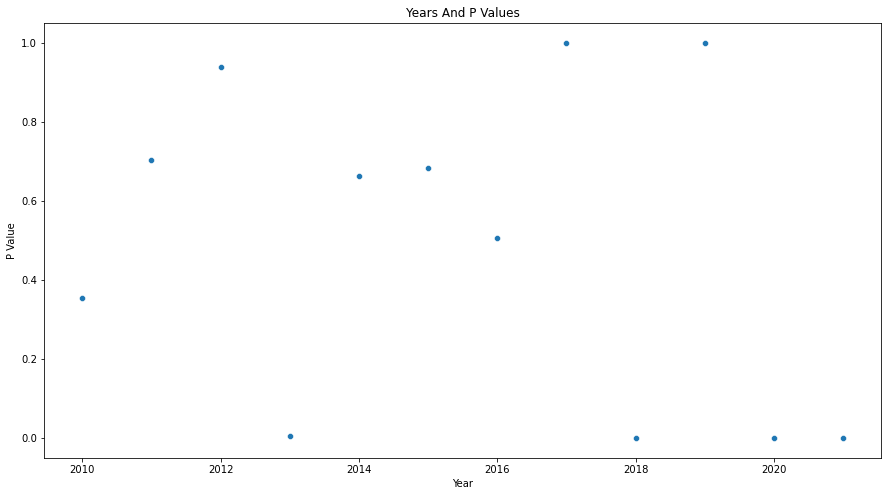

In [23]:
sns.scatterplot(x = year_p_vals.keys(), y = year_p_vals.values(), data=year_p_vals)
plt.xlabel("Year")
plt.ylabel("P Value")
plt.title("Years And P Values")
plt.show()

We can see that i most years, the p value does not allow us to reject $H_0$. However, we can see that in recent years the p values tend to get lower. In any case, we cannot reject the hypothesis that the rainfall does not dwindle over the years.  

#### Part 2.1.4

No, it wouldn't. Considering that we've tested on multiple years, we would have to adjust the p value calculation to the number of tests we are running to see real significance.

Also, we should remember that the p value is affected by both $n$, the sample size and $k$, the magnitude of the effect. If we have a very large sample size, the effect itself might be negligible while the p value is extremly small.

3) Consider the total amount of rainfall within each month. Suppose that we assume that there is no change in the distribution over time across years, but we suspect that December is usuallly rainier than February. Design a test procedure that checks whether this is true. Use two apporaches:
 - Two-sample t-test 
 - Paired t-test 
 - Which approach seems more approproate here? 

In [28]:
# I'll start with a two-sample t-test, asking whether Dec = Feb
# Afterward, I'll run a simple t-test, asking if Dec > Feb

alpha = 0.05

feb_data = data[data["Month"] == 2]
dec_data = data[data["Month"] == 12]

feb_gb_year_y = feb_data.groupby("Year").sum()["Rainfall"].values
dec_gb_year_y = dec_data.groupby("Year").sum()["Rainfall"].values

feb_n = feb_gb_year_y.shape[0]
dec_n = dec_gb_year_y.shape[0]

feb_year_y_mean = np.mean(feb_gb_year_y)
dec_year_y_mean = np.mean(dec_gb_year_y)

feb_year_y_std = np.std(feb_gb_year_y)
dec_year_y_std = np.std(dec_gb_year_y)

dof = dec_n + feb_n -2

two_sampled_s_squared = (np.sum((dec_gb_year_y - dec_year_y_mean)** 2)  + np.sum((feb_gb_year_y - feb_year_y_mean) ** 2) ) / dof

two_sampled_t_stat = (dec_year_y_mean - feb_year_y_mean) / np.sqrt(two_sampled_s_squared * (1 / feb_n + 1 / dec_n))


two_sampled_critical_value = st.t.ppf(1 - alpha/2, df=dof) 
two_sampled_t_stat_p_value = st.t.sf(two_sampled_t_stat, dof)
assert abs(two_sampled_t_stat_p_value) < two_sampled_critical_value

t_stat, p_val = st.ttest_ind(dec_gb_year_y, feb_gb_year_y)

print(f"The p value for Dec = Feb is {p_val}, therefore we can reject H_0 for alpha = 0.05")

The p value for Dec = Feb is 0.024136689735402964, therefore we can reject H_0 for alpha = 0.05


December and February are indeed different, next we'll see if Dec > Feb in a one sampled t test


In [29]:
one_sampled_s_sqaured = (1 / (dec_n - 1)) * np.sum((dec_gb_year_y - dec_year_y_mean) ** 2)

one_sampled_t_num = (dec_year_y_mean - feb_year_y_mean)
one_sampled_t_den = np.sqrt(one_sampled_s_sqaured) / np.sqrt(dec_n)

one_sampled_t = one_sampled_t_num / one_sampled_t_den

p_val = st.t.sf(one_sampled_t, dec_n)

print(f"The p value for Dec > Feb is {p_val:.3f}, therefore we can reject H_0 for alpha = 0.05")

The p value for Dec > Feb is 0.011, therefore we can reject H_0 for alpha = 0.05


next, I'll move on to the paired t test:

In [30]:
deltas = dec_gb_year_y - feb_gb_year_y

deltas_mean = np.mean(deltas)
dof = len(dec_gb_year_y) - 1

paired_s_squared =  (1 / dof) * np.sum((deltas - deltas_mean) ** 2)

paired_t_stat = deltas_mean / (np.sqrt(paired_s_squared / len(deltas)))
paired_critical_value = st.t.ppf(1 - alpha, df=dof)
paired_t_stat_p_value = st.t.sf(paired_t_stat, df=dof)

assert abs(paired_t_stat_p_value) < paired_critical_value

print(f"The p value for the paired test is {paired_t_stat_p_value:.3f}, therefore we can reject H_0 for alpha = 0.05")

The p value for the paired test is 0.024, therefore we can reject H_0 for alpha = 0.05


In this case, it seems that the paired test is the more accurate test. In this case, we do not assume that the data $within$ the year is independent, but assume that the data is independent only $between$ years. In this case, it is better to use the paired test and not the two-sampled test.